# CNN Benchmark: ConvNeXt-Tiny
## Phase 1: ASDID (Source) -> MH-Soya (Target)

This notebook evaluates the performance of a CNN model under Test-Time Adaptation (TTA) using TENT and EATA.

In [ ]:
%reload_ext autoreload
%autoreload 2

import torch
import os
import sys
from tqdm.notebook import tqdm

# Add root to path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.dataset.loaders import get_dataloaders
from src.model.architectures import get_model, configure_for_tta
from src.utils.metrics import calculate_metrics
from src.utils.plotting import plot_confusion_matrix, get_specific_errors, plot_specific_errors, plot_loss_curves
from src.utils.logging import set_seed, log_experiment, log_training_progress
from src.tent.optimizer import TentOptimizer
from src.eata.fisher import compute_fisher_diagonal
from src.eata.optimizer import EataOptimizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup & Configuration

In [5]:
SEED = 21
MODEL_NAME = "convnext_tiny"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
DATA_ASDID = "../data/ASDID"
DATA_MH = "../data/MH-SoyaHealthVision/Soyabean_Leaf_Image_Dataset"
CLASS_NAMES = ['Healthy', 'Rust', 'Frogeye']

set_seed(SEED)
print(f"Device: {DEVICE}")

Random seed set to: 21
Device: mps


## Step 1: Baseline Training on ASDID

We train on the USA (ASDID) data and evaluate the OOD performance on India (MH).

Loaded 4799 samples for ASDID dataset.
Loaded 1225 samples for MH dataset.
Model 'convnext_tiny' loaded and adapted for 3 classes.


Epoch 1:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/105 [00:00<?, ?it/s]

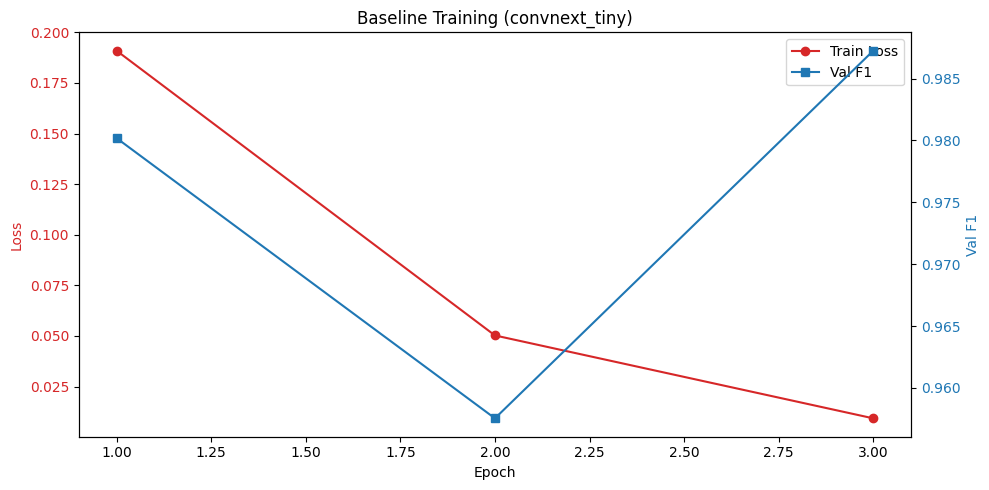

In [6]:
train_loader_asdid, val_loader_asdid, test_loader_asdid, dataset_asdid, _, _, _ = get_dataloaders("ASDID", DATA_ASDID, seed=SEED)
train_loader_mh, _, test_loader_mh, _, _, _, _ = get_dataloaders("MH", DATA_MH, seed=SEED)

model = get_model(MODEL_NAME, num_classes=3).to(DEVICE)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

EPOCHS = 3
best_val_f1 = 0
train_losses, val_f1s = [], []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for inputs, labels in tqdm(train_loader_asdid, desc=f"Epoch {epoch+1}", leave=False):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    # Validation
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader_asdid:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    metrics = calculate_metrics(all_labels, all_preds, CLASS_NAMES)
    val_f1s.append(metrics['F1'])
    train_losses.append(epoch_loss / len(train_loader_asdid))
    
    if metrics['F1'] > best_val_f1:
        best_val_f1 = metrics['F1']
        torch.save(model.state_dict(), f"best_{MODEL_NAME}.pth")

plot_loss_curves(train_losses, val_f1s, title=f"Baseline Training ({MODEL_NAME})")

### Evaluate Baseline on Target MH

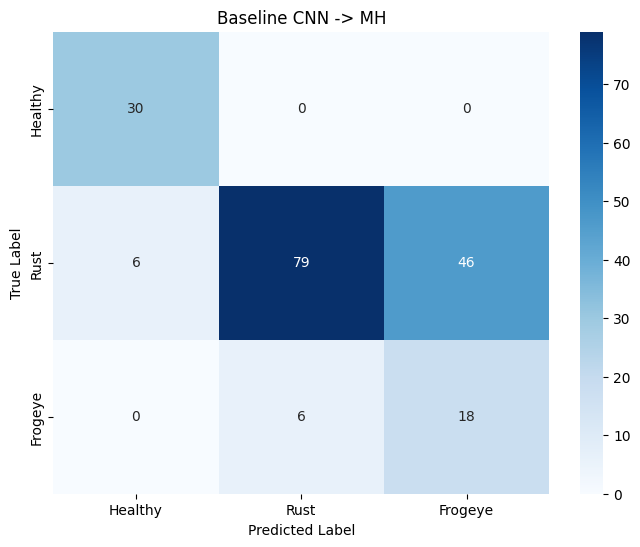

Experiment logged to results/experiment_logs/experiment_registry.csv


In [7]:
model.load_state_dict(torch.load(f"best_{MODEL_NAME}.pth"))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader_mh:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

metrics_baseline = calculate_metrics(all_labels, all_preds, CLASS_NAMES)
plot_confusion_matrix(metrics_baseline['Confusion_Matrix'], CLASS_NAMES, title=f"Baseline CNN -> MH")
log_experiment(f"{MODEL_NAME}_Baseline", SEED, MODEL_NAME, "ASDID", "MH", metrics_baseline, adaptation="None")

## Step 2: TENT Adaptation

Adapting normalization layers to minimize entropy on the unlabeled target stream.

Model 'convnext_tiny' loaded and adapted for 3 classes.
Model configured for TENT: 23 normalization layers unfrozen.
TENT: Adaptation completed (1 steps).


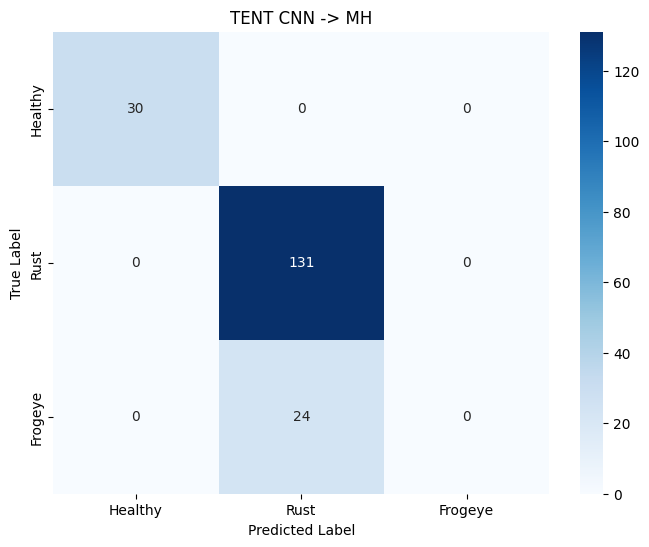

Experiment logged to results/experiment_logs/experiment_registry.csv


In [8]:
model_tent = get_model(MODEL_NAME, num_classes=3).to(DEVICE)
model_tent.load_state_dict(torch.load(f"best_{MODEL_NAME}.pth"))
model_tent = configure_for_tta(model_tent, method='tent')

tent_opt = TentOptimizer(model_tent, lr=1e-3, steps=1)
model_tent = tent_opt.run_adaptation(train_loader_mh, DEVICE) # Using target train as online stream

# Evaluation
model_tent.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader_mh:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model_tent(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

metrics_tent = calculate_metrics(all_labels, all_preds, CLASS_NAMES)
plot_confusion_matrix(metrics_tent['Confusion_Matrix'], CLASS_NAMES, title=f"TENT CNN -> MH")
log_experiment(f"{MODEL_NAME}_TENT", SEED, MODEL_NAME, "ASDID", "MH", metrics_tent, adaptation="TENT")

## Step 3: EATA Adaptation

Using Fisher Information to protect source knowledge while adapting.

Model 'convnext_tiny' loaded and adapted for 3 classes.
Model configured for EATA: 23 normalization layers unfrozen.
Computing Fisher matrix on source data...


Computing Fisher:   7%|▋         | 7/105 [00:26<06:13,  3.81s/it]


Fisher Diagonal Matrix computed.
EATA: Adaptation completed (1 steps).


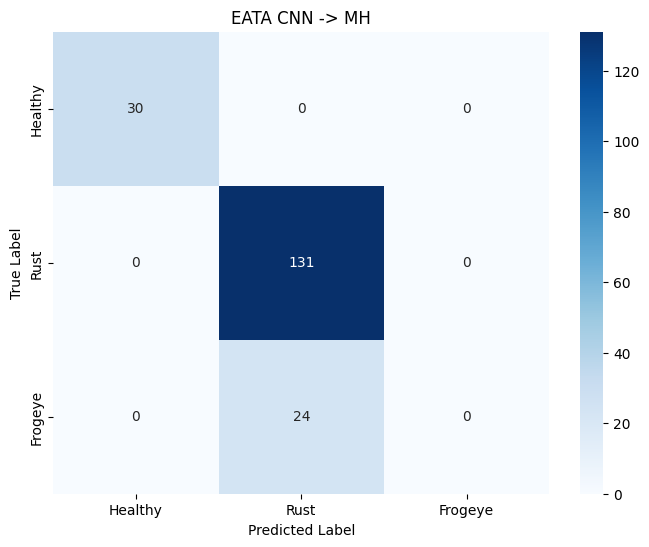

Experiment logged to results/experiment_logs/experiment_registry.csv


In [9]:
model_eata = get_model(MODEL_NAME, num_classes=3).to(DEVICE)
model_eata.load_state_dict(torch.load(f"best_{MODEL_NAME}.pth"))
model_eata = configure_for_tta(model_eata, method='eata')

# Crucial: Compute Fisher Diagonal on SOURCE data (ASDID)
print("Computing Fisher matrix on source data...")
fisher = compute_fisher_diagonal(model_eata, train_loader_asdid, DEVICE, num_samples=256)

eata_opt = EataOptimizer(model_eata, fisher, lr=1e-3, steps=1)
model_eata = eata_opt.run_adaptation(train_loader_mh, DEVICE)

# Evaluation
model_eata.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader_mh:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model_eata(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

metrics_eata = calculate_metrics(all_labels, all_preds, CLASS_NAMES)
plot_confusion_matrix(metrics_eata['Confusion_Matrix'], CLASS_NAMES, title=f"EATA CNN -> MH")
log_experiment(f"{MODEL_NAME}_EATA", SEED, MODEL_NAME, "ASDID", "MH", metrics_eata, adaptation="EATA")

## Visual Error Analysis


--- EATA Error Analysis: Frogeye as Rust ---


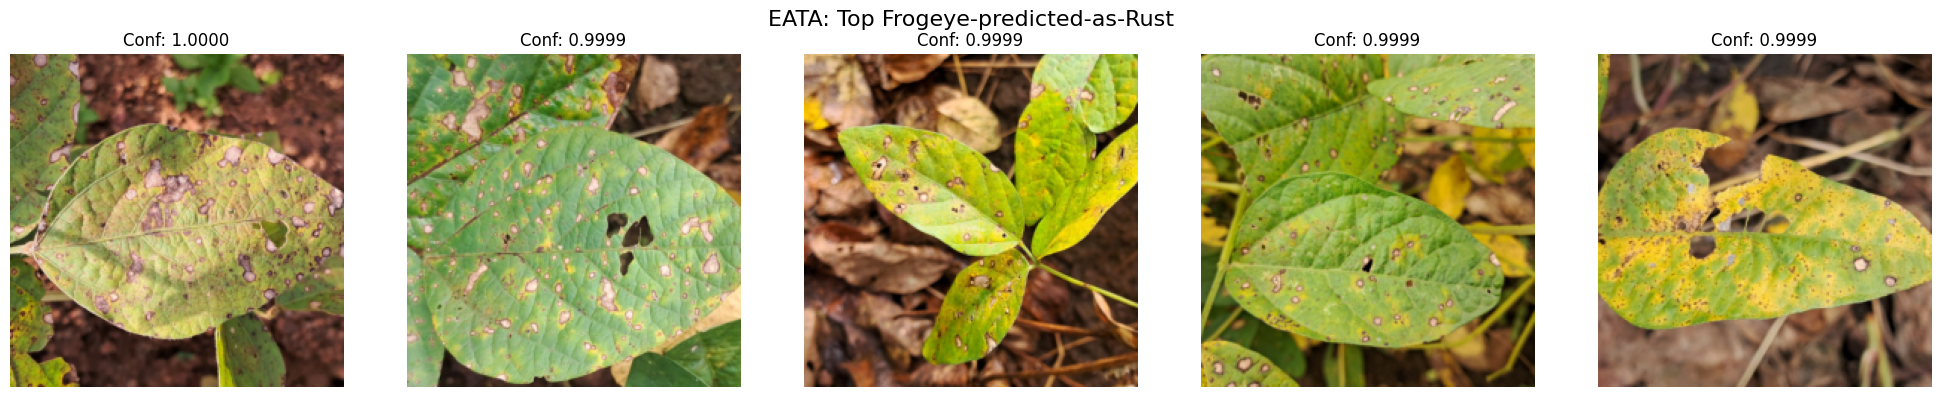

In [10]:
print("\n--- EATA Error Analysis: Frogeye as Rust ---")
errors = get_specific_errors(model_eata, test_loader_mh, DEVICE, CLASS_NAMES, "Frogeye", "Rust")
plot_specific_errors(errors, title="EATA: Top Frogeye-predicted-as-Rust")